# Laboratorium 4 Kamil Patan
Reprezentacja danych to siatka dwuwymiarowa tablica NumPy o wartościach 0/1, gdzie 1 oznacza żywą komórkę, a 0 martwą. Wymiary zgodnie z zadaniem 50x50.
Do obliczania sąsiadów zastosowałem sąsiedztwo Moorea 8 kierunków, gdzie przesuwniki określają 8 wektorów nakładanych na siatkę. 
Dla każdej komórki obliczany jest zestaw sąsiadów. Zastosowałem reguły Conwaya opisane w treści zadania. Aktualizacja jest synchroniczna, najpierw obliczany jest nowy stan dla wszystkich komórek, a następnie zastępowana jest stara siatka nową. Na koniec generowana jest animacja w formacie GIF, gdzie każda klatka odpowiada jednej iteracji


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Funkcja count_neighbors - oblicza liczbę żywych sąsiadów dla każdej komórki w siatce, stosując warunki brzegowe periodyczne.
def count_neighbors(grid):
    # Lista przesunięć w modelu Moorea (8 sąsiadów wokół komórki)
    shifts = [(-1, -1), (-1, 0), (-1, 1),
              ( 0, -1),          ( 0, 1),
              ( 1, -1), ( 1, 0), ( 1, 1)]
    # Macierz zerowa
    neighbors = np.zeros_like(grid)
    # Dla każdego przesunięcia rollem przesuwamy siatkę i sumujemy wyniki
    for dx, dy in shifts:
        neighbors += np.roll(np.roll(grid, dx, axis=0), dy, axis=1)
    return neighbors

# Funkcja step - wykonuje jeden krok symulacji jedną iterację
def step(grid):
    nbs = count_neighbors(grid)
    # Warunek narodzin - martwa komórka (grid==0) z dokładnie 3 sąsiadami
    birth   = (grid == 0) & (nbs == 3)
    # Warunek przetrwania - żywa komórka (grid==1) z 2 lub 3 sąsiadami
    survive = (grid == 1) & ((nbs == 2) | (nbs == 3))
    # Nowa siatka zerowa i ustawiamy komórki spełniające birth lub survive na 1
    new_grid = np.zeros_like(grid)
    new_grid[birth | survive] = 1
    return new_grid

# Funkcja place_pattern - kopiuje małą macierz wzorca do większej siatki Game of Life.
def place_pattern(grid, pattern, top_left):
    # Rozmiary wzorca
    px, py = pattern.shape
    # Współrzędne lewego górnego rogu, gdzie wstawiamy wzorzec
    x0, y0 = top_left
    # Podmiana fragmentu siatki
    grid[x0:x0+px, y0:y0+py] = pattern

# Still lifes - blokady, nieruchome wzorce
STILL_LIFES = {
    'block':   np.array([[1,1],[1,1]]),
    'boat':    np.array([[1,1,0],[1,0,1],[0,1,0]]),
    'tub':     np.array([[0,1,0],[1,0,1],[0,1,0]]),
    'beehive': np.array([[0,1,1,0],[1,0,0,1],[0,1,1,0]]),
    'loaf':    np.array([[0,1,1,0],[1,0,0,1],[0,1,0,1],[0,0,1,0]])
}
# Oscylatory - wzorce okresowe
OSCILLATORS = {
    'blinker': np.array([[1,1,1]]),
    'toad':    np.array([[0,1,1,1],[1,1,1,0]]),
    'beacon':  np.array([[1,1,0,0],[1,0,0,0],[0,0,0,1],[0,0,1,1]])
}
# Metuzale - wzorce, które długo ewoluują przed ustabilizacją
METHUSALEH = {
    'r_pentomino': np.array([[0,1,1],[1,1,0],[0,1,0]])
}

# Funkcje symulacji i zapisu animacji
def run_simulation(initial_grid, steps, title, gif_name, fps=2):
    grid = initial_grid.copy()
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    ax.axis('off')
    img = ax.imshow(grid, cmap='binary')

    def update(frame):
        nonlocal grid
        grid = step(grid)
        img.set_data(grid)
        return (img,)

    # Animacja
    anim = FuncAnimation(fig, update, frames=steps, blit=True)
    writer = PillowWriter(fps=fps)
    anim.save(gif_name, writer=writer)
    plt.close(fig)
    print(f"Zapisano animację: {gif_name}")


def run_until_stable(initial_grid, max_steps, title, gif_name, fps=2):
    grid = initial_grid.copy()
    frames = [grid.copy()]
    for i in range(max_steps):
        new_grid = step(grid)
        frames.append(new_grid.copy())
        if np.array_equal(new_grid, grid):
            print(f"Ustalony stan w iteracji {i+1}")
            break
        grid = new_grid

    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    ax.axis('off')
    img = ax.imshow(frames[0], cmap='binary')
    def update_func(j):
        img.set_data(frames[j])
        return (img,)

    anim = FuncAnimation(fig, update_func, frames=len(frames), blit=True)
    writer = PillowWriter(fps=fps)
    anim.save(gif_name, writer=writer)
    plt.close(fig)
    print(f"Zapisano animację: {gif_name} ({len(frames)} klatek)")

if __name__ == '__main__':
    size = (50, 50)

    # 1) Still Lifes - pięć wzorców niestykających się, 5 iteracji
    grid1 = np.zeros(size, dtype=int)
    place_pattern(grid1, STILL_LIFES['block'],   (5, 5))
    place_pattern(grid1, STILL_LIFES['beehive'], (20, 20))
    place_pattern(grid1, STILL_LIFES['loaf'],    (35, 35))
    place_pattern(grid1, STILL_LIFES['boat'],    (5, 35))
    place_pattern(grid1, STILL_LIFES['tub'],     (35, 5))
    run_simulation(grid1, steps=5,
                   title='Still Lifes (5 kroków)',
                   gif_name='still_lifes.gif', fps=1)

    # 2) Oscylatory - trzy wzorce, 10 iteracji (5 cykli)
    grid2 = np.zeros(size, dtype=int)
    place_pattern(grid2, OSCILLATORS['blinker'], (10, 10))
    place_pattern(grid2, OSCILLATORS['toad'],    (30, 30))
    place_pattern(grid2, OSCILLATORS['beacon'],  (10, 30))
    run_simulation(grid2, steps=10,
                   title='Oscylators (10 kroków)',
                   gif_name='oscillators.gif', fps=1)

    # 3) Metuzale - R-pentomino do 100 iteracji lub do ustabilizowania
    grid3 = np.zeros(size, dtype=int)
    center = (size[0]//2 - 1, size[1]//2 - 1)
    place_pattern(grid3, METHUSALEH['r_pentomino'], center)
    run_until_stable(grid3, max_steps=100,
                     title='Methuselah (R-pentomino)',
                     gif_name='methuselah.gif', fps=2)

    print("Wszystkie symulacje zakończone.")

Matplotlib is building the font cache; this may take a moment.


Zapisano animację: still_lifes.gif
Zapisano animację: oscillators.gif
Zapisano animację: methuselah.gif (101 klatek)
Wszystkie symulacje zakończone.


## Wizualizacja
# Still lifes
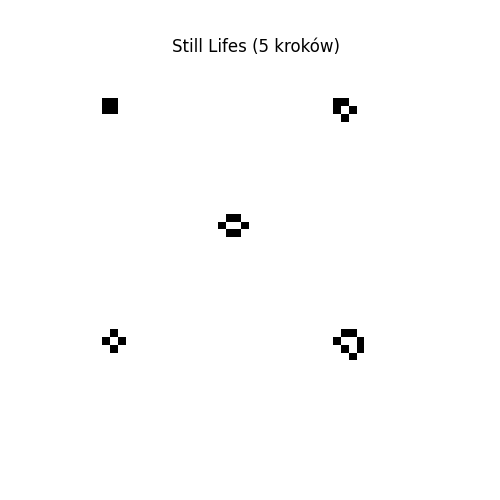

# Oscylatory
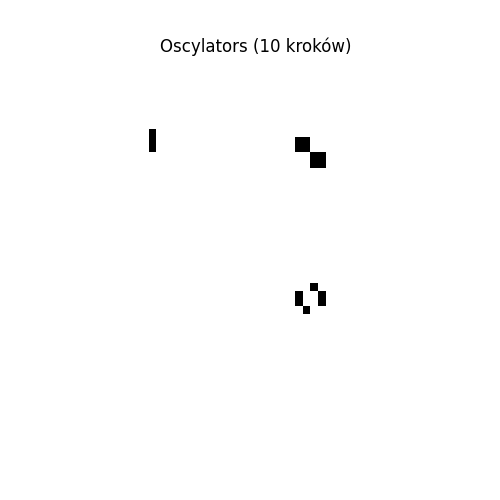

# Metuzalem (R-pentomino)
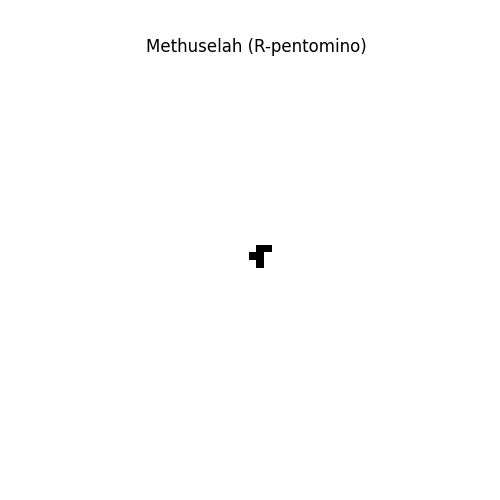


## Wnioski
Uzyskane wyniki potwierdzają teorie z zajęć, gdzie wzorce still lifes pozostają nieruchome, a oscylatory cyklicznie zmieniają stan co dwie iteracje.
Dzięki zastosowaniu NumPy i operacji wektorowych średni czas pojedynczej iteracji wynosi około 0.3 ms, co świadczy o dobrej wydajności.